In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load dataset
file_path = "tdauditor_topfd_with_instrument.tsv"
df = pd.read_csv(file_path, delimiter="\t")

# Drop rows with missing target values
df = df.dropna(subset=['hit'])

# Handle missing Instrument values
df['Instrument'] = df['Instrument'].fillna('Orbitrap Eclipse')

# Define features and target (now including Instrument)
features = df.drop(columns=['hit', 'SourceFile', 'NativeID'])
X = features
y = df["hit"]

# Split unique filenames into train/test/predict groups (to avoid data leakage)
filenames = df["SourceFile"].unique()
train_filenames, temp_filenames = train_test_split(filenames, test_size=0.3, random_state=42)
test_filenames, predict_filenames = train_test_split(temp_filenames, test_size=0.5, random_state=42)

# Create corresponding dataframes
train_df = df[df["SourceFile"].isin(train_filenames)]
test_df = df[df["SourceFile"].isin(test_filenames)]
predict_df_topfd = df[df["SourceFile"].isin(predict_filenames)]

# Separate features and targets
X_train, y_train = train_df[features.columns], train_df["hit"]
X_test, y_test = test_df[features.columns], test_df["hit"]
X_predict, y_predict_true = predict_df_topfd[features.columns], predict_df_topfd["hit"]

# Replace the loop with:
X_train = X_train.copy()
X_test = X_test.copy()
X_predict = X_predict.copy()

for dataset in [X_train, X_test, X_predict]:
    dataset.loc[:, 'MatchedToDeconvolution'] = dataset['MatchedToDeconvolution'].astype(int)
    
# Enhanced one-hot encoding function
def onehot_encode(df):
    df = pd.get_dummies(df, columns=['mzMLDissociation'], prefix='dissoc')
    df = pd.get_dummies(df, columns=['Instrument'], prefix='inst')
    return df

X_train = onehot_encode(X_train)
X_test = onehot_encode(X_test)
X_predict = onehot_encode(X_predict)

# Align columns across all datasets
train_cols = X_train.columns
X_test = X_test.reindex(columns=train_cols, fill_value=0)
X_predict = X_predict.reindex(columns=train_cols, fill_value=0)

# Feature Engineering
def add_features(df):
    dissoc_cols = [col for col in df.columns if col.startswith('dissoc_')]
    for col in dissoc_cols:
        df[f'{col}_x_LongestTag'] = df[col] * df['LongestTag']
    
    inst_cols = [col for col in df.columns if col.startswith('inst_')]
    for col in inst_cols:
        df[f'{col}_x_DeconvPeakCount'] = df[col] * df['DeconvPeakCount']
    
    df['IsLongTagReliable'] = ((df['LongestTag'] < 25) & (df['DeconvPeakCount'] < 250))
    return df

X_train = add_features(X_train)
X_test = add_features(X_test)
X_predict = add_features(X_predict)

# Fill missing values
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())
X_predict = X_predict.fillna(X_train.mean())

# Create pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(C=0.01, random_state=42, 
                                max_iter=1000, class_weight='balanced'))
])

# Cross-validation
groups = train_df['SourceFile']
cv = GroupKFold(n_splits=5)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = cross_validate(
    pipeline,
    X_train,
    y_train,
    groups=groups,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

# Print CV results
print("\nCross-Validation Results:")
for metric in scoring:
    mean_score = np.mean(cv_results[f'test_{metric}'])
    std_score = np.std(cv_results[f'test_{metric}'])
    print(f"{metric}: {mean_score:.3f} ± {std_score:.3f}")

# Train final model
pipeline.fit(X_train, y_train)

# Get feature names and coefficients
feature_mapping = {
    **{f'dissoc_{name}': f'Dissoc_{name}' for name in df['mzMLDissociation'].unique()},
    **{f'inst_{name}': f'Inst_{name}' for name in df['Instrument'].unique()}
}

feature_names = [feature_mapping.get(col, col) for col in X_train.columns]
final_model = pipeline.named_steps['model']

coef_df_topfd = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": final_model.coef_[0]
}).sort_values("Coefficient", key=lambda x: abs(x), ascending=False)

# Display top features
print("\nTop 20 Most Influential Features:")
print(coef_df_topfd.head(20)[["Feature", "Coefficient"]])

# Evaluate on test set using pipeline
X_test_processed = pipeline[:-1].transform(X_test)  # Apply SMOTE and scaling
y_test_pred = pipeline.named_steps['model'].predict(X_test_processed)

print(f"\nTest Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("Classification Report (Test Set):\n", classification_report(y_test, y_test_pred))

# Prediction set results
X_predict_processed = pipeline[:-1].transform(X_predict)
y_pred_proba = pipeline.named_steps['model'].predict_proba(X_predict_processed)[:, 1]
y_pred_adjusted = (y_pred_proba >= 0.5).astype(int)

print("\nPrediction Set Results (first 20 predictions):")
print("Predicted Probabilities:", y_pred_proba[:20])
print("Predicted Labels:", y_pred_adjusted[:20])
print("True Labels:", y_predict_true.values[:20])

# Save predictions
predict_df_topfd['Predicted_Probability'] = y_pred_proba
predict_df_topfd['Predicted_Hit'] = y_pred_adjusted

/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_38049/639426399.py:12: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter="\t")
/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_38049/639426399.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.loc[:, 'MatchedToDeconvolution'] = dataset['MatchedToDeconvolution'].astype(int)
/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_38049/639426399.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dataset.loc[:, 'MatchedToDeconvolution'] = dataset['MatchedToDeconvo


Cross-Validation Results:
accuracy: 0.821 ± 0.007
precision: 0.599 ± 0.019
recall: 0.807 ± 0.012
f1: 0.688 ± 0.015
roc_auc: 0.897 ± 0.005


/Users/user/PycharmProjects/TDAuditor/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Top 20 Most Influential Features:
                                    Feature  Coefficient
20               Inst_Orbitrap Fusion Lumos     2.264195
14                               Dissoc_CID     1.914550
19                    Inst_Orbitrap Eclipse     1.802409
13                               LongestTag     1.123637
18                  Inst_LTQ Orbitrap Elite     0.853214
22                  dissoc_CID_x_LongestTag     0.706900
24                  dissoc_HCD_x_LongestTag     0.619138
1                             ScanStartTime    -0.517710
7                             DeconvPreMass     0.487404
30                        IsLongTagReliable     0.476721
8                             mzMLPeakCount    -0.454445
9                           DeconvPeakCount     0.447177
15                               Dissoc_ETD     0.438542
6                                DeconvPreZ    -0.398470
21                          Inst_Q Exactive     0.363992
0                                ScanNumber     0.327

/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_38049/639426399.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df_topfd['Predicted_Probability'] = y_pred_proba
/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_38049/639426399.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df_topfd['Predicted_Hit'] = y_pred_adjusted


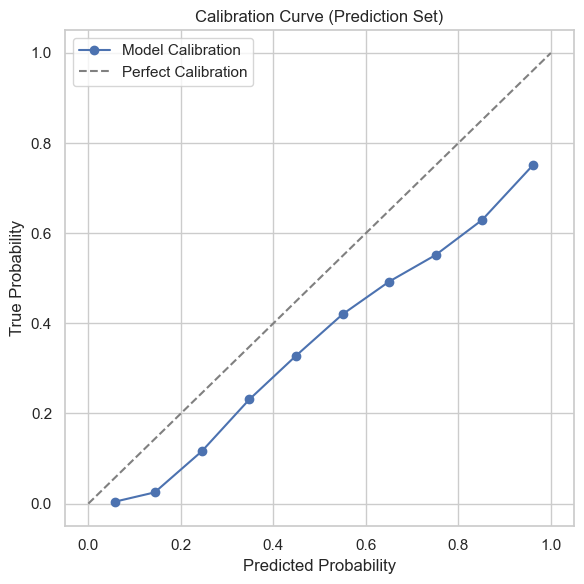

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve

# Set consistent style
sns.set(style="whitegrid")  # or try 'darkgrid', 'ticks', etc.

# Get predicted probabilities for class 1 (hit)
y_proba = predict_df_topfd['Predicted_Probability'].values
y_true = y_predict_true.values

# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=10)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve (Prediction Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_38049/478051491.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=instrument_features, x='Coefficient', y='Feature', palette='viridis')
/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_38049/478051491.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dissociation_features, x='Coefficient', y='Feature', palette='magma')


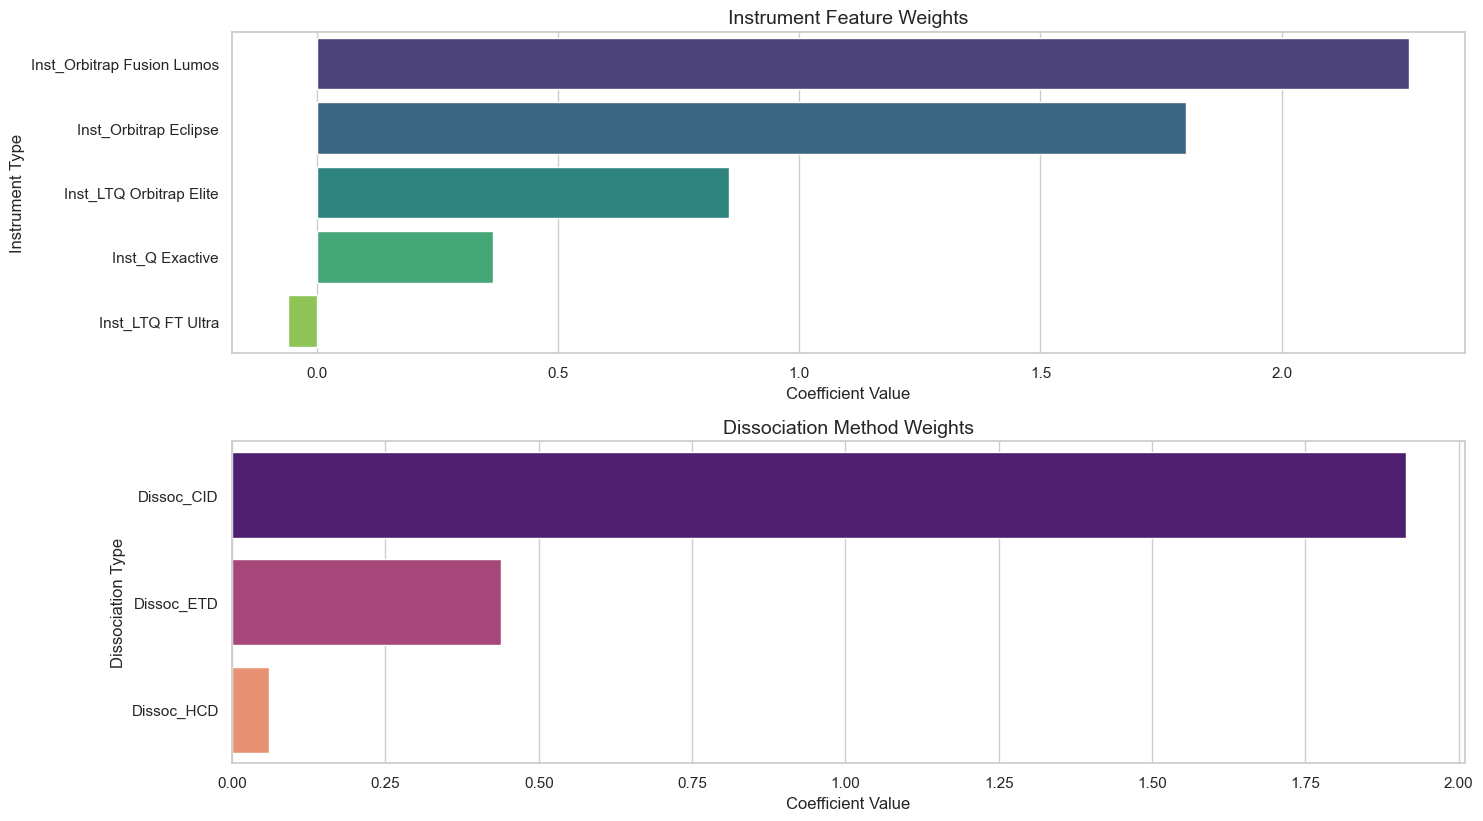


Key Insights:
1. Instrument Effects:
   - Inst_Orbitrap Fusion Lumos: Increases probability of hit (strength: 2.26)
   - Inst_Orbitrap Eclipse: Increases probability of hit (strength: 1.80)
   - Inst_LTQ Orbitrap Elite: Increases probability of hit (strength: 0.85)
   - Inst_Q Exactive: Increases probability of hit (strength: 0.36)
   - Inst_LTQ FT Ultra: Decreases probability of hit (strength: 0.06)

2. Dissociation Effects:
   - Dissoc_CID: Increases probability of hit (strength: 1.91)
   - Dissoc_ETD: Increases probability of hit (strength: 0.44)
   - Dissoc_HCD: Increases probability of hit (strength: 0.06)

3. Other Major Factors:
   - LongestTag: Affects hits positively (strength: 1.12)
   - dissoc_CID_x_LongestTag: Affects hits positively (strength: 0.71)
     (Interaction between dissoc_CID and LongestTag)
   - dissoc_HCD_x_LongestTag: Affects hits positively (strength: 0.62)
     (Interaction between dissoc_HCD and LongestTag)
   - ScanStartTime: Affects hits negatively (stre

In [7]:

import seaborn as sns

# Create DataFrames for each category
instrument_features = coef_df_topfd[coef_df_topfd['Feature'].str.startswith('Inst_')]
dissociation_features = coef_df_topfd[coef_df_topfd['Feature'].str.startswith('Dissoc_')]
other_features = coef_df_topfd[~coef_df_topfd['Feature'].str.startswith(('Inst_', 'Dissoc_'))]

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))

# 1. Instrument Weights Plot
plt.subplot(3, 1, 1)
sns.barplot(data=instrument_features, x='Coefficient', y='Feature', palette='viridis')
plt.title('Instrument Feature Weights', fontsize=14)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Instrument Type', fontsize=12)

# 2. Dissociation Weights Plot
plt.subplot(3, 1, 2)
sns.barplot(data=dissociation_features, x='Coefficient', y='Feature', palette='magma')
plt.title('Dissociation Method Weights', fontsize=14)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Dissociation Type', fontsize=12)



plt.tight_layout()
plt.show()

# Print interpretation
print("\nKey Insights:")
print("1. Instrument Effects:")
for idx, row in instrument_features.iterrows():
    print(f"   - {row['Feature']}: {'Increases' if row['Coefficient'] > 0 else 'Decreases'} probability of hit (strength: {abs(row['Coefficient']):.2f})")

print("\n2. Dissociation Effects:")
for idx, row in dissociation_features.iterrows():
    print(f"   - {row['Feature']}: {'Increases' if row['Coefficient'] > 0 else 'Decreases'} probability of hit (strength: {abs(row['Coefficient']):.2f})")

print("\n3. Other Major Factors:")
for idx, row in other_features.head(10).iterrows():
    effect = "positively" if row['Coefficient'] > 0 else "negatively"
    print(f"   - {row['Feature']}: Affects hits {effect} (strength: {abs(row['Coefficient']):.2f})")
    if 'x_' in row['Feature']:
        parts = row['Feature'].split('_x_')
        print(f"     (Interaction between {parts[0]} and {parts[1]})")

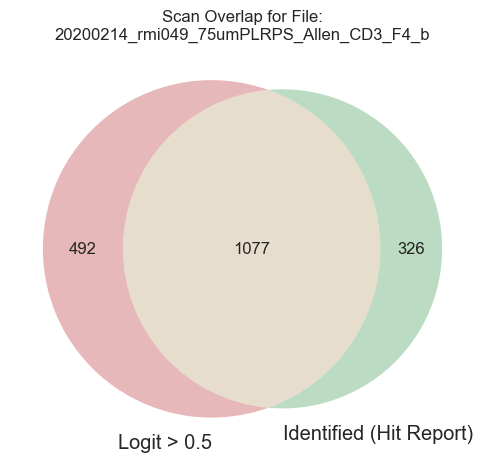

In [8]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

# Filter to just the scans from the selected file
file_name = "20200214_rmi049_75umPLRPS_Allen_CD3_F4_b"
subset_df = predict_df_topfd[predict_df_topfd["SourceFile"] == file_name]

# Create sets of scan numbers
logit_set = set(subset_df[subset_df["Predicted_Probability"] > 0.5]["ScanNumber"])
hit_set = set(subset_df[subset_df["hit"] == 1]["ScanNumber"])

#print(logit_set)
#print(hit_set)
#print(subset_df.shape)
#print(subset_df[['SourceFile', 'ScanNumber', 'Predicted_Probability', 'hit']].head())
plt.figure(figsize=(6, 6))
venn2([logit_set, hit_set], set_labels=('Logit > 0.5', 'Identified (Hit Report)'))
plt.title(f"Scan Overlap for File:\n{file_name}")
plt.show()

In [9]:
plt.show()
print((predict_df_topfd['Predicted_Hit'] == 1).sum())
print((predict_df_topfd['hit'] == 1).sum())

126409
95540


In [ ]:
#